<a href="https://colab.research.google.com/github/ramaastra/sekarya-machine-learning/blob/main/sekarya_model_with_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sekarya Machine Learning Model (Development)

This notebook containing some experiments of machine learning model development for Sekarya's main feature, to classify wheter an artwork is generated by AI or not.

For the model itself, the training will be done with a custom dataset we've collected below. For addition to the imbalanced ai_generated class in the dataset, we also add more data from Kaggle.

- [Sekarya Dataset](https://drive.google.com/drive/folders/1W_DN02xlxOB9M_P27_TJJNuhdxEQY9Kf?usp=drive_link)
- [Addition AI-generated Dataset](https://www.kaggle.com/datasets/gauravduttakiit/dalle-recognition-dataset)

## Preparing the Dataset

### Getting the Sekarya Dataset from Google Drive

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/New-Sekarya-Dataset/

test  train


In [3]:
drive_dataset_dir = '/content/drive/MyDrive/New-Sekarya-Dataset/'
os.listdir(drive_dataset_dir)

['train', 'test']

In [4]:
drive_train_dir = os.path.join(drive_dataset_dir, 'train')
os.listdir(drive_train_dir)

['ai_generated', 'non_ai_generated']

In [5]:
drive_train_fake_dir = os.path.join(drive_train_dir, 'ai_generated')
drive_train_real_dir = os.path.join(drive_train_dir, 'non_ai_generated')

print(f'There are {len(os.listdir(drive_train_fake_dir))} images of fake (AI-generated) artworks for training.\n')
print(f'There are {len(os.listdir(drive_train_real_dir))} images of real (human-made artworks) images for training.\n')

There are 331 images of fake (AI-generated) artworks for training.

There are 2501 images of real (human-made artworks) images for training.



### Getting Additional Dataset from Kaggle

In [6]:
from google.colab import files
import os

if not(os.path.exists("kaggle.json")):
  files.upload()
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=b13c41fddab86b4b2fc22187a7f2e69bebd7354f93f60e7f945bb075e8d93878
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
kaggle.json


In [7]:
dataset_url = 'gauravduttakiit/dalle-recognition-dataset'
dataset_name = dataset_url.split('/')[1]
!kaggle datasets download -d  {dataset_url}
!mkdir {dataset_name}
!unzip -q {dataset_name}.zip -d {dataset_name}
!rm -f {dataset_name}.zip

100% 1.35G/1.35G [01:21<00:00, 17.1MB/s]
100% 1.35G/1.35G [01:21<00:00, 17.8MB/s]


In [8]:
kaggle_train_fake_dir = f'/content/{dataset_name}/train/fake'
print(f'There are {len(os.listdir(kaggle_train_fake_dir))} additional images of fake (AI-generated) artworks for training.\n')

There are 2057 additional images of fake (AI-generated) artworks for training.



### Storing Data File Paths and Labels to a List

In [9]:
images = []
labels = []

# Dataset from Google Drive
class_labels = os.listdir(drive_train_dir)
for class_label in class_labels:
  class_data_path = os.path.join(drive_train_dir, class_label)
  for filename in os.listdir(class_data_path):
    file_path = os.path.join(class_data_path, filename)
    images.append(file_path)
    labels.append(class_label)

# Additional AI-generated class data from Kaggle
for filename in os.listdir(kaggle_train_fake_dir):
  file_path = os.path.join(kaggle_train_fake_dir, filename)
  images.append(file_path)
  labels.append('ai_generated')

print(f'There are {len(images)} images will be splitted with K-fold cross-validation technique.\n')

There are 4889 images will be splitted with K-fold cross-validation technique.



## Preparing the Model Architecture

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import random

### Defining a Function to Handle Model Creation

In [17]:
def create_model(pretrained=False):
  model = tf.keras.Sequential()

  if pretrained:
    vgg19 = VGG19(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')

    for layer in vgg19.layers:
      layer.trainable = False

    model.add(vgg19)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))

  else:
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

### Defining EarlyStopping Callback

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               mode='min',
                               restore_best_weights=True)

## Creating Models

In [ ]:
cnn_model = create_model()
cnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 26, 26, 128)     

In [18]:
vgg19_model = create_model(pretrained=True)
vgg19_model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               3211392   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                       

## Training the Model with K-fold Cross-validation

In [14]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)

In [15]:
def train_kfold(model, model_name):
  for k, (train_indices, val_indices) in enumerate(kfold.split(images, labels)):
    print(f'[Processing Fold-{k}...]\n')

    # Creating lists for images and labels based on the train and val indices
    x_train = [images[i] for i in train_indices]
    y_train = [labels[i] for i in train_indices]
    x_val = [images[i] for i in val_indices]
    y_val = [labels[i] for i in val_indices]

    # Creating dataframe for each train and val list
    train_df = pd.DataFrame({
      'image': x_train,
      'label': y_train
    })
    val_df = pd.DataFrame({
      'image': x_val,
      'label': y_val
    })

    # Creating the image generator to process the images
    train_datagen = ImageDataGenerator(rescale=1./255.0)
    val_datagen = ImageDataGenerator(rescale=1./255.0)

    train_generator = train_datagen.flow_from_dataframe(train_df,
                                                        x_col='image',
                                                        y_col='label',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        color_mode='rgb',
                                                        class_mode='binary')

    val_generator = val_datagen.flow_from_dataframe(val_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode='rgb',
                                                    class_mode='binary')

    print()

    # Train the model for this fold
    history = model.fit(train_generator,
                        epochs=20,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(val_generator, verbose=0)
    print(f'\nValidation accuracy for fold-{k}: {accuracy:.4f}')

    print('\n==============================================================\n')

  # Save the model into models directory
  model.save(f'/content/models/{model_name}.h5')

In [ ]:
train_kfold(cnn_model, 'cnn_model')

[Processing Fold-0...]

Found 3911 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.

Epoch 1/20
123/123 [==============================] - 77s 611ms/step - loss: 0.6630 - accuracy: 0.5855 - val_loss: 0.5474 - val_accuracy: 0.6810
Epoch 2/20
123/123 [==============================] - 74s 604ms/step - loss: 0.5528 - accuracy: 0.7149 - val_loss: 0.4134 - val_accuracy: 0.8231
Epoch 3/20
123/123 [==============================] - 75s 614ms/step - loss: 0.5053 - accuracy: 0.7535 - val_loss: 0.3563 - val_accuracy: 0.8487
Epoch 4/20
123/123 [==============================] - 85s 695ms/step - loss: 0.4561 - accuracy: 0.7914 - val_loss: 0.4189 - val_accuracy: 0.7730
Epoch 5/20
123/123 [==============================] - 76s 616ms/step - loss: 0.4308 - accuracy: 0.8039 - val_loss: 0.2824 - val_accuracy: 0.8967
Epoch 6/20
123/123 [==============================] - 75s 610ms/step - loss: 0.3962 - accuracy: 0.8231 - val_loss: 0.2822 - val_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
train_kfold(vgg19_model, 'vgg19_model')

[Processing Fold-0...]

Found 3911 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.

Epoch 1/20
123/123 [==============================] - 85s 666ms/step - loss: 0.5523 - accuracy: 0.7100 - val_loss: 0.3838 - val_accuracy: 0.8333
Epoch 2/20
123/123 [==============================] - 82s 666ms/step - loss: 0.3887 - accuracy: 0.8284 - val_loss: 0.3390 - val_accuracy: 0.8609
Epoch 3/20
123/123 [==============================] - 89s 716ms/step - loss: 0.3185 - accuracy: 0.8722 - val_loss: 0.3200 - val_accuracy: 0.8671
Epoch 4/20
123/123 [==============================] - 80s 646ms/step - loss: 0.2564 - accuracy: 0.8980 - val_loss: 0.2884 - val_accuracy: 0.8763
Epoch 5/20
123/123 [==============================] - 90s 735ms/step - loss: 0.1998 - accuracy: 0.9322 - val_loss: 0.3094 - val_accuracy: 0.8691
Epoch 6/20
123/123 [==============================] - 90s 732ms/step - loss: 0.1667 - accuracy: 0.9427 - val_loss: 0.2938 - val_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluating the Model with Confusion Matrix

### Getting the Test Set from Kaggle

In [20]:
from google.colab import files
import os

if not(os.path.exists("kaggle.json")):
  files.upload()
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.16-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
kaggle.json


In [21]:
dataset_url = 'macayanpioloc/ai-generated-and-human-made-painting'
dataset_name = dataset_url.split('/')[1]
!kaggle datasets download -d  {dataset_url}
!mkdir {dataset_name}
!unzip -q {dataset_name}.zip -d {dataset_name}
!rm -f {dataset_name}.zip

100% 406M/407M [00:23<00:00, 17.7MB/s]
100% 407M/407M [00:23<00:00, 18.2MB/s]


In [22]:
test_dir = f'/content/{dataset_name}/224/val'
os.listdir(test_dir)

['AI_GENERATED', 'NON_AI_GENERATED']

### Evaluating Model Predictions on the Test Set

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255.0)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  target_size=(224, 224))

Found 5884 images belonging to 2 classes.


In [24]:
# True label for the test set
y_true = test_generator.classes

In [25]:
# Loading the model
model = tf.keras.models.load_model('/content/models/vgg19_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               3211392   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23244097 (88.67 MB)
Trainable params: 32

In [26]:
# Generating predictions with the model to the test set
predictions = model.predict(test_generator)

184/184 [==============================] - 36s 193ms/step


In [35]:
# Converting the probabilites into binary class
threshold = 0.5
y_pred = (predictions > threshold).astype(int)

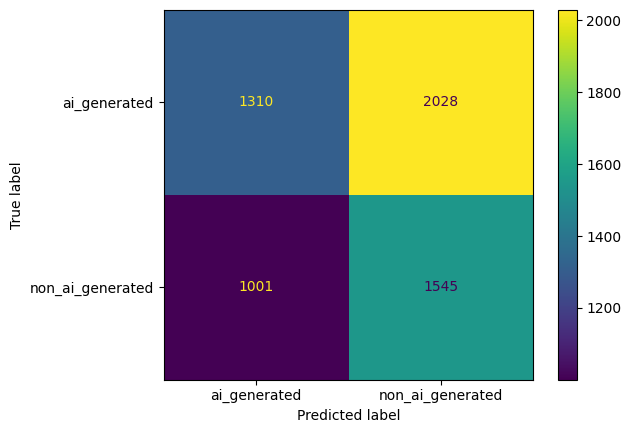

In [36]:
# Creating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['ai_generated', 'non_ai_generated'])
disp.plot()